In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


In [2]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
X, y = np.array(X) / 255.0, np.array(y, dtype=int)
X, y = X[:6000], y[:6000]

In [3]:
def bootstrap_sample(X, y):
    """Generates a bootstrap sample of the dataset."""
    n_samples = X.shape[0]
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    oob_indices = list(set(range(n_samples)) - set(indices))
    return X[indices], y[indices], X[oob_indices], y[oob_indices]

In [4]:
def knn_oob_accuracy(X, y, k, num_iterations=10):
    """Compute mean OOB accuracy for KNN with a specific k over multiple bootstrap iterations."""
    oob_accuracies = []
    
    for _ in range(num_iterations):
        X_train, y_train, X_oob, y_oob = bootstrap_sample(X, y)
        
        # Train KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Predict on out-of-bag samples
        y_pred_oob = knn.predict(X_oob)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_oob, y_pred_oob)
        oob_accuracies.append(accuracy)
    
    # Return the mean OOB accuracy over the bootstrap iterations
    return np.mean(oob_accuracies)


In [5]:
def evaluate_knn_accuracies(X, y, k_values, bootstrap_iterations_list):
    """Evaluate KNN accuracies for different values of k and bootstrap iterations."""
    results = {}
    
    for k in k_values:
        results[k] = []
        for num_iterations in bootstrap_iterations_list:
            mean_oob_accuracy = knn_oob_accuracy(X, y, k, num_iterations)
            results[k].append((num_iterations, mean_oob_accuracy))
    
    return results


In [6]:
# Define values of k and bootstrap iterations to test
k_values = [1, 3, 5, 7, 9]  # Range of k-values to test
bootstrap_iterations_list = [1, 2, 11, 22, 44, 88]  # Different numbers of bootstrap iterations


In [7]:
# Run evaluation
results = evaluate_knn_accuracies(X, y, k_values, bootstrap_iterations_list)

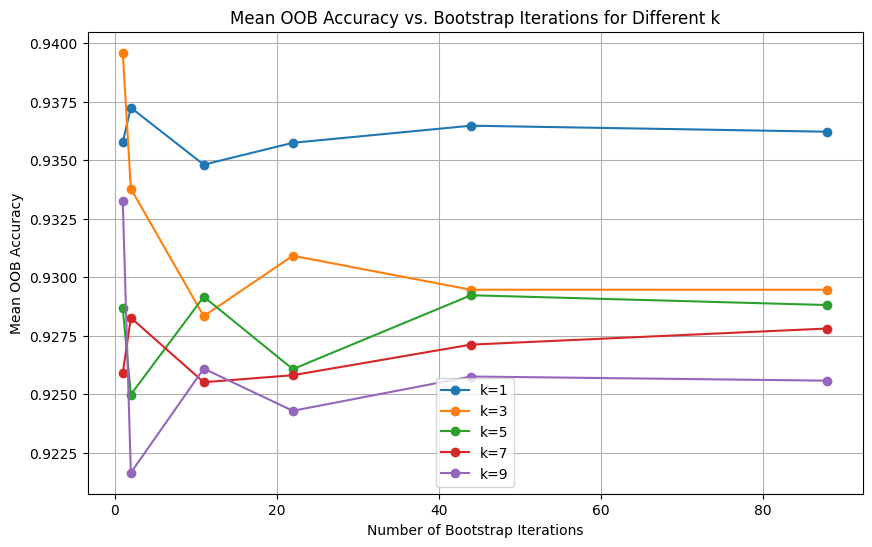

In [8]:
# Plot mean accuracy for each value of k
plt.figure(figsize=(10, 6))

for k in k_values:
    bootstrap_iterations, accuracies = zip(*results[k])
    plt.plot(bootstrap_iterations, accuracies, marker='o', label=f'k={k}')

plt.xlabel('Number of Bootstrap Iterations')
plt.ylabel('Mean OOB Accuracy')
plt.title('Mean OOB Accuracy vs. Bootstrap Iterations for Different k')
plt.legend()
plt.grid(True)
plt.show()


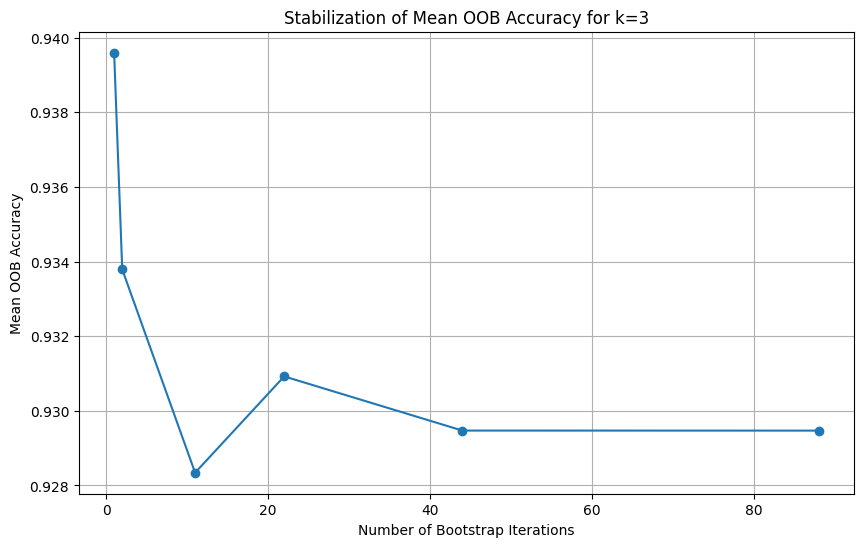

In [9]:
# Find the best performing k based on the results
best_k = max(results, key=lambda k: max([acc for _, acc in results[k]]))

# Plot stabilization for the best k
bootstrap_iterations, accuracies = zip(*results[best_k])

plt.figure(figsize=(10, 6))
plt.plot(bootstrap_iterations, accuracies, marker='o')
plt.xlabel('Number of Bootstrap Iterations')
plt.ylabel('Mean OOB Accuracy')
plt.title(f'Stabilization of Mean OOB Accuracy for k={best_k}')
plt.grid(True)
plt.show()
